# Evaluating Sharpness Preservation

Get 10% and 50% MTFs for fbp, red-cnn, and red-cnn augmentation

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
phantom_dir = base_dir / 'CTP404_peds'
meta = pd.read_csv(phantom_dir / 'metadata.csv')
meta

,Name,phantom,effective diameter [cm],FOV [cm],recon,Dose [%],file,simulated,kernel,scanner
0,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN augmented,10,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
1,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN,10,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
2,35.0 mm CTP404,CTP404,35.0,38.5,fbp,10,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
3,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN augmented,40,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
4,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN,40,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
...,...,...,...,...,...,...,...,...,...,...
187,15.1 mm CTP404,CTP404,15.1,16.6,RED-CNN,70,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
188,15.1 mm CTP404,CTP404,15.1,16.6,fbp,70,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
189,15.1 mm CTP404,CTP404,15.1,16.6,RED-CNN augmented,85,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
190,15.1 mm CTP404,CTP404,15.1,16.6,RED-CNN,85,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition


1. move the CTP404 phantom simulations from `/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404` to `/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds` - **done**
2. add metaheaders to make them easier to load, with pixel size and recon info? -> dicom eventually for this last one - **done**
3. make metadata csv like for CCT189 - **done**

4. make sure Ct numbers have 0 offset, so air == -1000, water == 0 - **done**
5. run denoisers on the CTP dataset - **done**
6. then run /home/brandon.nelson/Dev/DLIR_Ped_Generalizability/geometric_phantom_studies/evaluation/MTF

In [3]:
import SimpleITK as sitk
vol = sitk.ReadImage(meta.file[0])
vol.GetDepth(), vol.GetWidth(), vol.GetHeight()

(20, 512, 512)

In [4]:
meta[(meta['Dose [%]']==25)&
     (meta['effective diameter [cm]']==35)&
     (meta['FOV [cm]']==38.5)]

,Name,phantom,effective diameter [cm],FOV [cm],recon,Dose [%],file,simulated,kernel,scanner
9,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN augmented,25,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
10,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN,25,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
11,35.0 mm CTP404,CTP404,35.0,38.5,fbp,25,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition


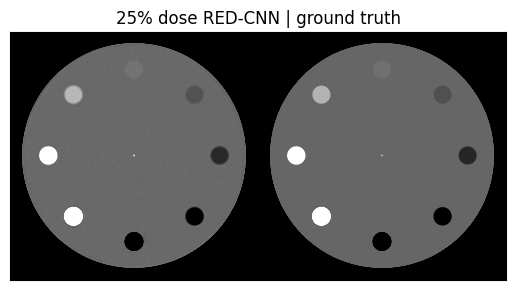

In [5]:
from results_utils import browse_studies, study_viewer
browse_studies(meta, phantom='CTP404', diameter=35, fov=38.5, dose=25, recon='RED-CNN')

In [6]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404',), value='CTP404'), Dropdown(descripti…

## Measuring MTF

### Selecting HU-Specific ROIs

In [7]:
from utils import get_ground_truth, load_mhd
import SimpleITK as sitk
row = meta[(meta['Dose [%]']==1000)&(meta['effective diameter [cm]']==11.2)].iloc[0]
file = row.file

gt_file = get_ground_truth(file)
file, gt_file

('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter112mm/dose_1000/RED-CNN augmented/112mm_dose_1000_RED-CNN augmented.mhd',
 PosixPath('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter112mm/true.mhd'))

In [8]:
img = load_mhd(file)
gt_img = load_mhd(gt_file)

In [9]:
contrast_locations = pd.read_csv('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404/monochromatic/diameter150mm/phantom_info_pix_idx.csv')
contrast_locations.rename(columns=dict(zip(contrast_locations.columns, list(map(lambda o: o.strip(), contrast_locations.columns)))), inplace=True)
water_attenuation_coefficient = contrast_locations[contrast_locations['x radius'] == contrast_locations['x radius'].max()]['mu [60 keV]'].item()
contrast_locations['Contrast [HU]'] = round((contrast_locations['mu [60 keV]'])/water_attenuation_coefficient*1000)
contrast_locations.loc[contrast_locations['mu [60 keV]']==water_attenuation_coefficient, 'Contrast [HU]'] = 0 
contrast_locations

,x center,y center,x radius,y radius,angle degree,mu [60 keV],Contrast [HU]
0,256,256,112.94000,112.94000,0,0.020590,0.0
1,256,342,9.03530,9.03530,0,0.000309,15.0
2,317,317,9.03530,9.03530,0,-0.000721,-35.0
3,342,256,9.03530,9.03530,0,-0.002059,-100.0
4,317,195,9.03530,9.03530,0,-0.004118,-200.0
5,256,170,9.03530,9.03530,0,-0.020590,-1000.0
6,195,195,9.03530,9.03530,0,0.020384,990.0
7,170,256,9.03530,9.03530,0,0.007001,340.0
8,195,317,9.03530,9.03530,0,0.002471,120.0
9,256,256,0.37647,0.37647,0,0.123540,6000.0


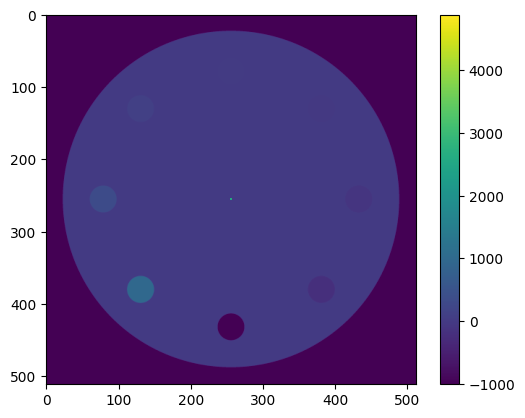

In [10]:
plt.imshow(gt_img)
plt.colorbar()

In [11]:
np.unique(gt_img), len(np.unique(gt_img))

(array([-1000,  -937,  -875,  -812,  -750,  -688,  -687,  -625,  -562,
         -500,  -437,  -375,  -312,  -250,  -200,  -187,  -175,  -163,
         -150,  -137,  -125,  -113,  -100,   -94,   -87,   -81,   -75,
          -69,   -63,   -62,   -56,   -50,   -44,   -38,   -37,   -35,
          -33,   -31,   -28,   -26,   -25,   -24,   -22,   -20,   -19,
          -18,   -17,   -15,   -13,   -12,   -11,    -9,    -6,    -4,
           -2,     0,     1,     2,     3,     4,     5,     6,     7,
            8,     9,    10,    11,    12,    13,    14,    15,    21,
           30,    38,    43,    45,    53,    60,    62,    64,    68,
           75,    83,    85,    90,    98,   105,   106,   113,   120,
          124,   128,   149,   170,   191,   213,   234,   247,   248,
          255,   276,   298,   309,   319,   340,   371,   433,   495,
          557,   619,   681,   742,   743,   804,   866,   928,   990,
         4875], dtype=int16),
 118)

There should be no more than 10 unique values in the ground truth image (8 inserts + background + foreground)

In [12]:
row

Name                                                          11.2 mm CTP404
phantom                                                               CTP404
effective diameter [cm]                                                 11.2
FOV [cm]                                                                12.3
recon                                                      RED-CNN augmented
Dose [%]                                                                1000
file                       /gpfs_projects/brandon.nelson/PediatricCTSizeD...
simulated                                                               True
kernel                                                                   D45
scanner                                           Siemens Somatom Definition
Name: 54, dtype: object

863.7314997350071


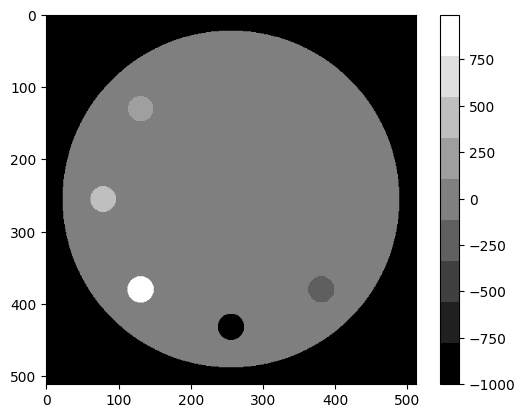

In [13]:
from skimage import measure
def deblur_ground_truth(gt_img, size_thresh=1000):
    label_image = measure.label(gt_img, background=-1000)
    mask = np.zeros_like(label_image)
    for label in np.unique(label_image):
        if (np.sum(label_image==label) < size_thresh): continue
        mask[label_image==label]=gt_img[label_image==label]
    return mask

pixel_size_mm = sitk.ReadImage(file).GetSpacing()[0]
min_area_mm2 = 50
size_thresh_pixels = min_area_mm2/(pixel_size_mm**2)
print(size_thresh_pixels)
gt_img = load_mhd(gt_file)
gt_img = deblur_ground_truth(gt_img, size_thresh=min_area_mm2/(pixel_size_mm**2))
plt.imshow(gt_img, cmap=plt.get_cmap('gray', len(np.unique(gt_img))))
plt.colorbar()

In [14]:
np.unique(gt_img), len(np.unique(gt_img))

(array([-1000,  -200,  -100,   -35,     0,    15,   120,   340,   990]), 9)

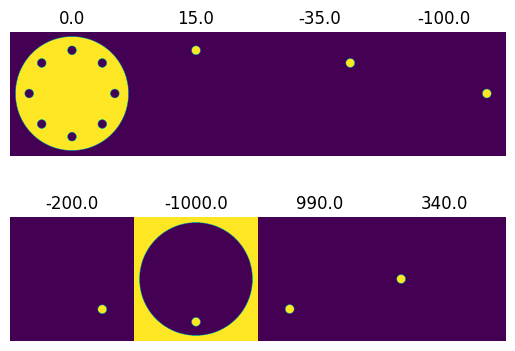

In [15]:
from skimage import data, util, measure
f, axs = plt.subplots(2,4, sharex=True, sharey=True, gridspec_kw=dict(hspace=0, wspace=0))
for ax, HU in zip(axs.flatten(), contrast_locations['Contrast [HU]']):
    ax.imshow(gt_img==HU) #label = 0 is background, 1 is the largest object
    ax.set_title(HU)
    ax.axis('off')

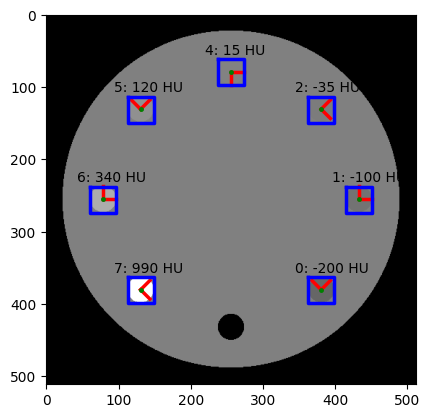

In [16]:
import math

regions = measure.regionprops(gt_img+1000)

fig, ax = plt.subplots()
ax.imshow(gt_img, cmap=plt.cm.gray)
for idx, props in enumerate(regions):
    if (props.label - 1000) == 0:
        continue
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=5)
    ax.annotate(f'{idx}: {props.label-1000} HU', (x0-props.axis_major_length, y0-props.axis_major_length/1.5))

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
plt.show()

In [17]:
region = regions[0]
center = region.centroid
radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
center, radius

((380.5560928433269, 380.5560928433269), 18.140329555163042)

Text(0.5, 1.0, '800')

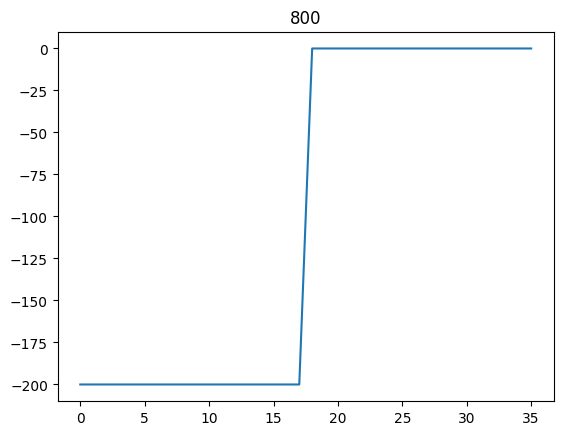

In [18]:
plt.plot(gt_img[round(center[0]):round(center[0]+2*radius):,round(center[0]):round(center[0]+1)])
plt.title(region.label)

Now add radial averaging... and loop through all contrasts and do this for all recons to get ESF --> MTF --> MTF10, MTF50

In [19]:
import numpy as np

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [20]:
def radial_profile(img, center, radius, angle, num=None):
    if num is None:
        num = np.ceil(radius).astype(int)
    coords = np.round(np.array(list(map(lambda r: pol2cart(r, phi=0), np.linspace(0, radius, num=num))))+center).astype(int) 
    return [img[x,y] for x, y in coords]

len(radial_profile(gt_img, center, 2*radius, 0))

37

In [21]:
meta[meta['Dose [%]']==1000]

,Name,phantom,effective diameter [cm],FOV [cm],recon,Dose [%],file,simulated,kernel,scanner
6,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN augmented,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
7,35.0 mm CTP404,CTP404,35.0,38.5,RED-CNN,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
8,35.0 mm CTP404,CTP404,35.0,38.5,fbp,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
30,15.0 mm CTP404,CTP404,15.0,34.0,RED-CNN augmented,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
31,15.0 mm CTP404,CTP404,15.0,34.0,RED-CNN,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
32,15.0 mm CTP404,CTP404,15.0,34.0,fbp,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
54,11.2 mm CTP404,CTP404,11.2,12.3,RED-CNN augmented,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
55,11.2 mm CTP404,CTP404,11.2,12.3,RED-CNN,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
56,11.2 mm CTP404,CTP404,11.2,12.3,fbp,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition
78,18.5 mm CTP404,CTP404,18.5,20.4,RED-CNN augmented,1000,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,D45,Siemens Somatom Definition


In [22]:
import seaborn as sns


def measure_esf(file, nangles=4):
    """
    Measures edqe spread functions at `nangles` equi-radially spaced for each contrast
    """
    distances = []
    profiles = []
    degrees = []
    contrasts = []
    series = []

    img = load_mhd(file)
    gt_img = load_mhd(get_ground_truth(file))
    pixel_size_mm = sitk.ReadImage(file).GetSpacing()[0]
    min_area_mm2 = 50
    size_thresh_pixels = min_area_mm2/(pixel_size_mm**2)
    gt_img = deblur_ground_truth(gt_img, size_thresh=size_thresh_pixels)

    regions = measure.regionprops(gt_img+1000)
    angles = np.linspace(0, 180, nangles)

    for region in regions:
        contrast = region.label - 1000
        if contrast == 0: continue
        center = region.centroid
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        for deg in angles:
            rad = np.deg2rad(deg)
            gt_profile = radial_profile(gt_img, center=center, radius=2*radius, angle=rad)
            img_profile = list(np.mean([radial_profile(repeat, center=center, radius=2*radius, angle=rad) for repeat in img], axis=0))
            degrees = degrees + len(gt_profile)*[deg] + len(img_profile)*[deg]
            distances = distances + list(range(len(gt_profile))) + list(range(len(img_profile)))
            profiles = profiles + gt_profile + img_profile
            contrasts = contrasts + len(gt_profile)*[contrast] + len(img_profile)*[contrast]
            series =  series + len(gt_profile)*['truth'] + len(img_profile)*['image']
    esf = pd.DataFrame({'series': series,
                        'contrast': contrasts,
                        'angle [degree]': degrees,
                        'distance': distances,
                        'ESF': profiles})
    return esf

file = meta[meta['Dose [%]']==1000].iloc[0].file
esf = measure_esf(file)
esf

,series,contrast,angle [degree],distance,ESF
0,truth,-200,0.0,0,-200.000000
1,truth,-200,0.0,1,-200.000000
2,truth,-200,0.0,2,-200.000000
3,truth,-200,0.0,3,-200.000000
4,truth,-200,0.0,4,-200.000000
...,...,...,...,...,...
2067,image,990,180.0,32,0.371103
2068,image,990,180.0,33,0.372147
2069,image,990,180.0,34,0.024203
2070,image,990,180.0,35,0.118820


In [23]:
file

'/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/dose_1000/RED-CNN augmented/350mm_dose_1000_RED-CNN augmented.mhd'

In [24]:
from tqdm import tqdm

df_list = []
for idx, row in tqdm(meta[meta['Dose [%]']==1000].iterrows()):
    file = row.file
    esf = measure_esf(file)
    esf['effective diameter [cm]']=row['effective diameter [cm]']
    esf['FOV [cm]']=row['FOV [cm]']
    esf['recon']=row['recon']
    esf.loc[esf['series']=='truth', 'recon'] = 'truth'
    esf['Dose [%]']=row['Dose [%]']
    df_list.append(esf)
esf = pd.concat(df_list, ignore_index=True)
esf

24it [00:09,  2.61it/s]


,series,contrast,angle [degree],distance,ESF,effective diameter [cm],FOV [cm],recon,Dose [%]
0,truth,-200,0.0,0,-200.00,35.0,38.5,truth,1000
1,truth,-200,0.0,1,-200.00,35.0,38.5,truth,1000
2,truth,-200,0.0,2,-200.00,35.0,38.5,truth,1000
3,truth,-200,0.0,3,-200.00,35.0,38.5,truth,1000
4,truth,-200,0.0,4,-200.00,35.0,38.5,truth,1000
...,...,...,...,...,...,...,...,...,...
46531,image,990,180.0,32,-0.55,15.1,16.6,fbp,1000
46532,image,990,180.0,33,-0.05,15.1,16.6,fbp,1000
46533,image,990,180.0,34,-0.30,15.1,16.6,fbp,1000
46534,image,990,180.0,35,-0.20,15.1,16.6,fbp,1000


In [25]:
esf.recon.unique()

array(['truth', 'RED-CNN augmented', 'RED-CNN', 'fbp'], dtype=object)

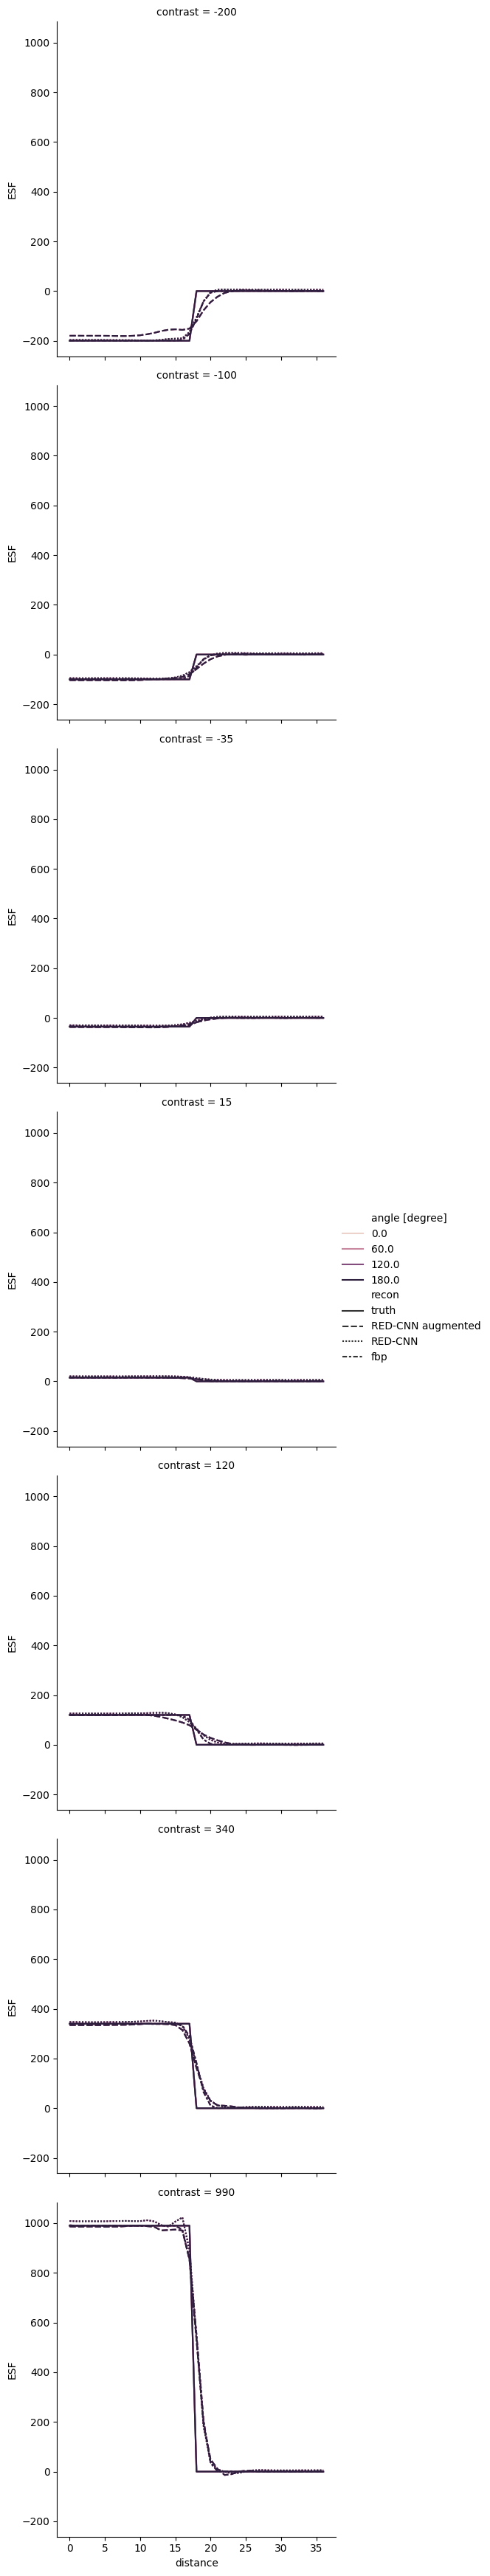

In [26]:
sns.relplot(data=esf[esf['effective diameter [cm]']==15.1], x='distance', y='ESF', hue='angle [degree]', style='recon', kind='line', row='contrast')

### Average across angles

In [27]:
def measure_averaged_esf(file, nangles=180):
    esf = measure_esf(file, nangles=nangles)
    radial_mean_esf = esf.groupby(['series', 'contrast', 'distance']).mean('ESF')
    df_list = []
    for series in esf['series'].unique():
        for contrast in esf['contrast'].unique():
            temp = esf[(esf['series']==series)&(esf['contrast']==contrast)&(esf['angle [degree]']==0)].copy().set_index('distance')
            temp.pop('angle [degree]')
            temp['ESF'] = radial_mean_esf['ESF'][series, contrast]
            df_list.append(temp.reset_index())
    return pd.concat(df_list, ignore_index=True)

In [28]:
avg_esf = measure_averaged_esf(file)
avg_esf

,distance,series,contrast,ESF
0,0,truth,-200,-200.00
1,1,truth,-200,-200.00
2,2,truth,-200,-200.00
3,3,truth,-200,-200.00
4,4,truth,-200,-200.00
...,...,...,...,...
513,32,image,990,-0.55
514,33,image,990,-0.05
515,34,image,990,-0.30
516,35,image,990,-0.20


<Axes: xlabel='distance', ylabel='ESF'>

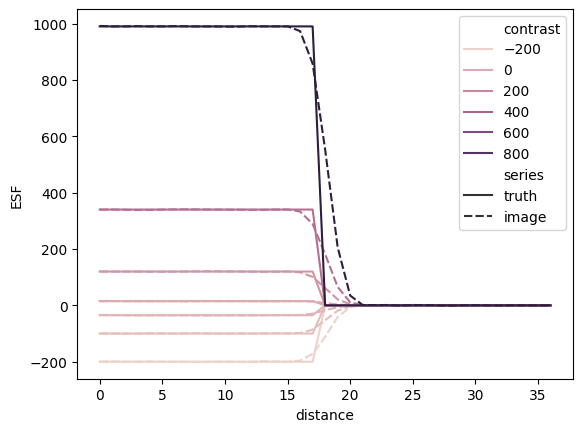

In [29]:
avg_esf = measure_averaged_esf(file, nangles=180)
sns.lineplot(data=avg_esf, x='distance', y='ESF', hue='contrast', style='series')

In [37]:
from tqdm import tqdm
nangles=180

esf_csv = Path('esf.csv')

if not esf_csv.exists():
    df_list = []
    for idx, row in tqdm(meta.iterrows()):
        file = row.file
        avg_esf = measure_averaged_esf(file, nangles=180)
        avg_esf['effective diameter [cm]']=row['effective diameter [cm]']
        avg_esf['FOV [cm]']=row['FOV [cm]']
        avg_esf['recon']=row['recon']
        avg_esf.loc[esf['series']=='truth', 'recon'] = 'truth'
        avg_esf['Dose [%]']=row['Dose [%]']
        df_list.append(avg_esf)
    avg_esf = pd.concat(df_list, ignore_index=True)
    avg_esf['distance [cm]'] = avg_esf['distance'] * avg_esf['FOV [cm]']/512
    avg_esf.rename(columns={'distance':'distance [pixels]'})
    avg_esf.to_csv(esf_csv, index=False)

avg_esf = pd.read_csv(esf_csv)
avg_esf

,distance,series,contrast,ESF,effective diameter [cm],FOV [cm],recon,Dose [%],distance [cm]
0,0,truth,-200,-200.00,35.0,38.5,truth,10,0.000000
1,1,truth,-200,-200.00,35.0,38.5,truth,10,0.075195
2,2,truth,-200,-200.00,35.0,38.5,truth,10,0.150391
3,3,truth,-200,-200.00,35.0,38.5,truth,10,0.225586
4,4,truth,-200,-200.00,35.0,38.5,truth,10,0.300781
...,...,...,...,...,...,...,...,...,...
93067,32,image,990,-1.75,15.1,16.6,fbp,85,1.037500
93068,33,image,990,1.10,15.1,16.6,fbp,85,1.069922
93069,34,image,990,4.00,15.1,16.6,fbp,85,1.102344
93070,35,image,990,5.75,15.1,16.6,fbp,85,1.134766


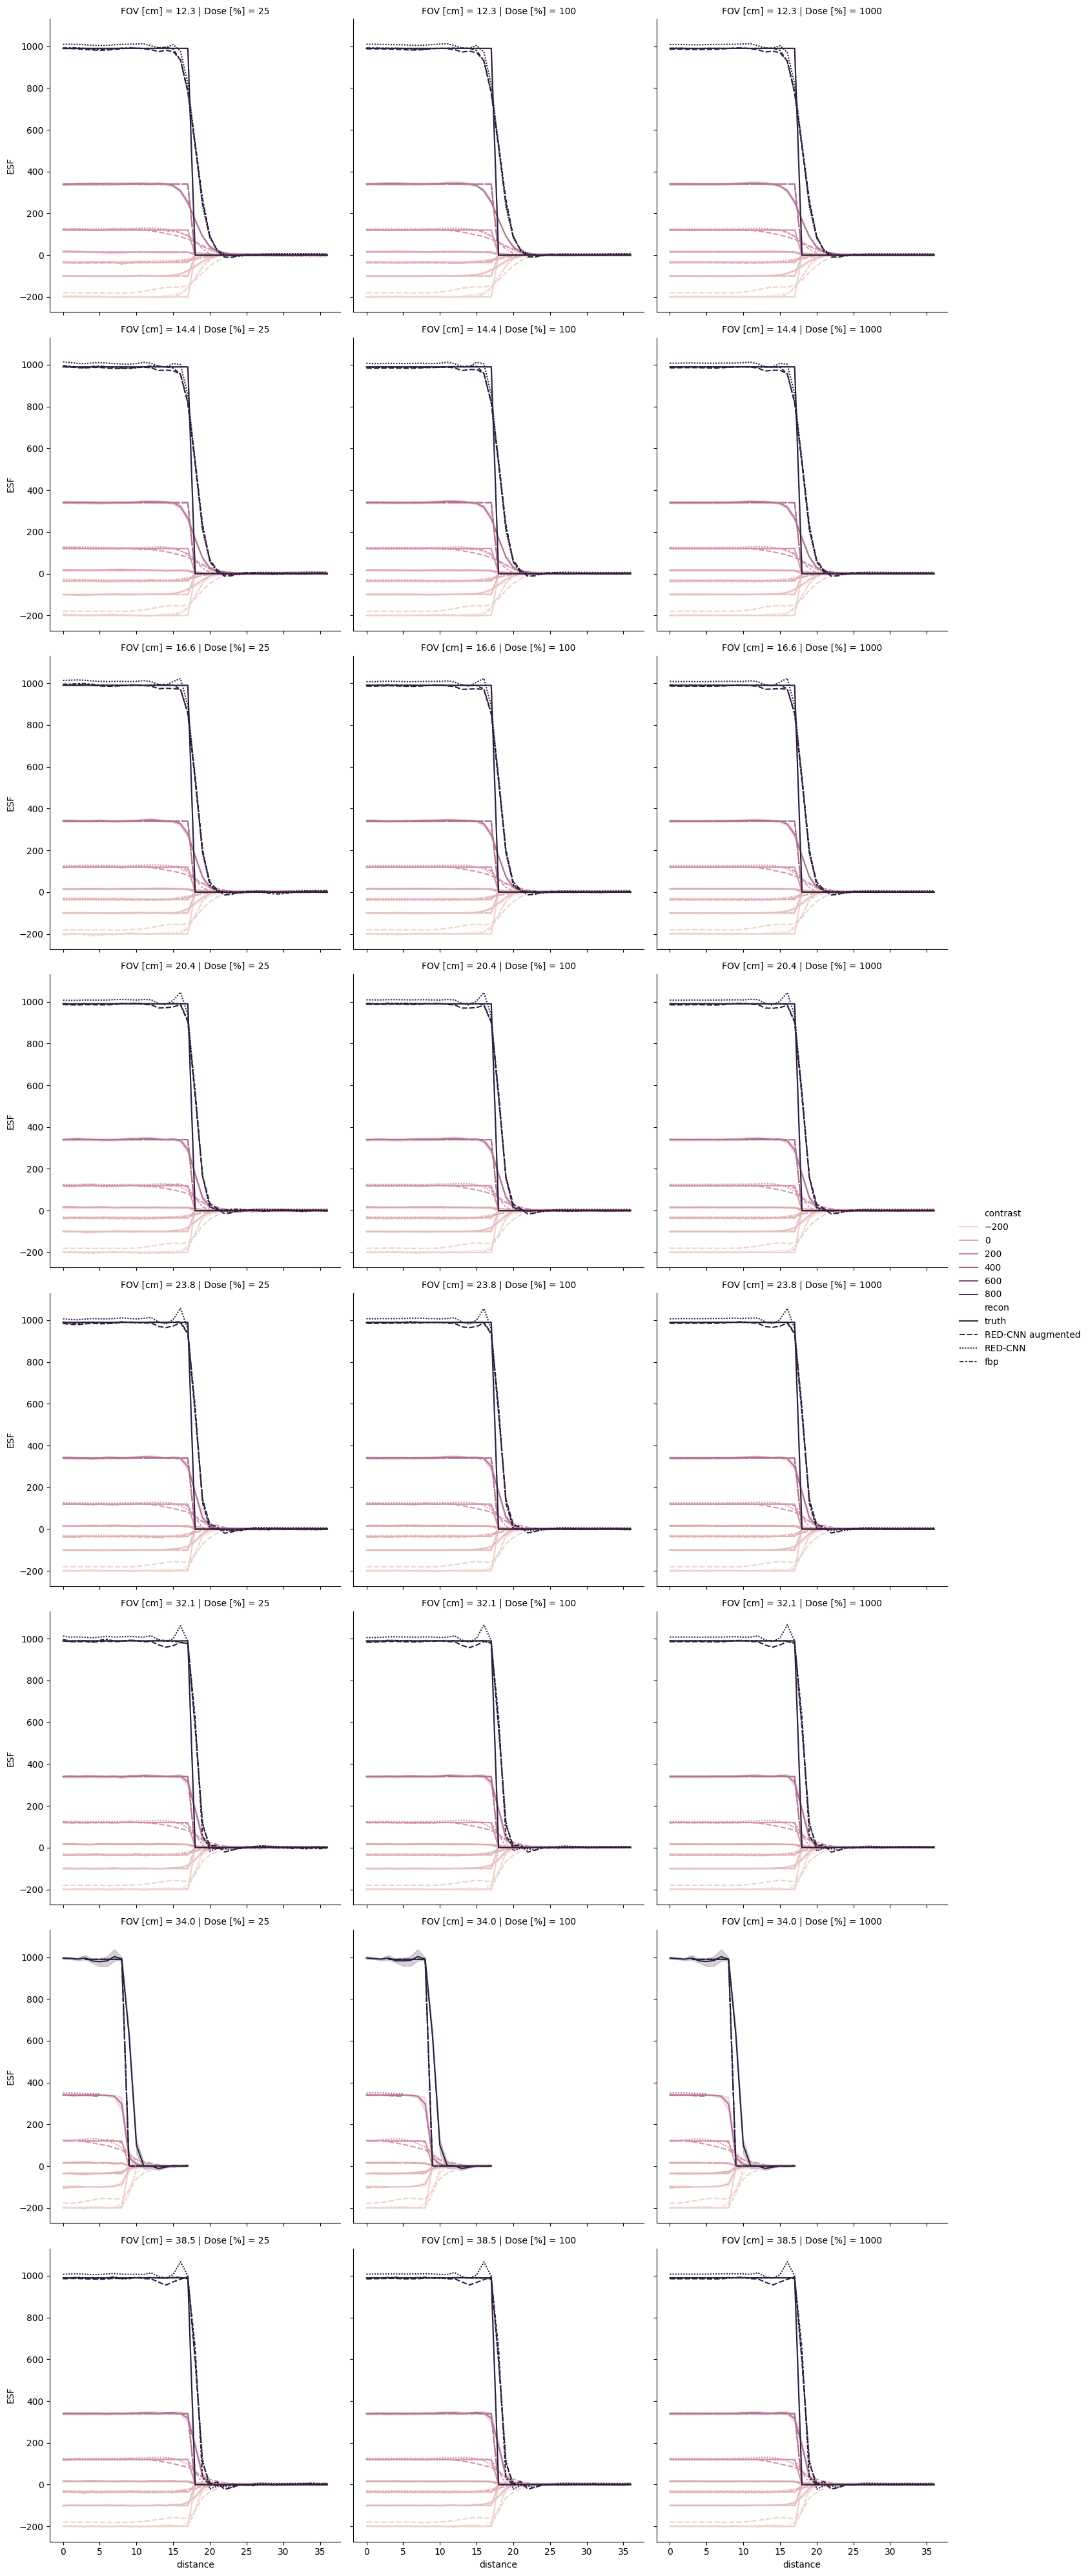

In [31]:
sns.relplot(data=avg_esf[avg_esf['Dose [%]'].isin([25, 100, 1000])], x='distance', y='ESF', hue='contrast', style='recon', kind='line', row='FOV [cm]', col='Dose [%]')